# 不均衡データに対する二値分類評価指標の挙動: 補足資料

Python言語で書いている

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn import metrics

# 実験用コードの準備

In [2]:
class EvaluateSimulator:
    def __init__(self, iter: int=100):
        self.iter = iter

        self.rng: np.ndarray = np.random.default_rng(seed=42)
        self.scores: dict[str, dict[float, list[float]]] = {}

    def scores_init(self) -> None:
        self.scores = {
            "accuracy": {},
            "ppv": {},
            "npv": {},
            "sensitivity": {},
            "specificity": {},
            "f1-score": {},
            "mcc": {},
            "g-mean": {},
            "roc-auc": {},
            "pr-auc": {},
        }
    
    def process(self, posi_rates: list[float]) -> None:
        self.scores_init()

        for posi_rate in posi_rates:
            for key in self.scores.keys():
                self.scores[key][posi_rate] = []

            for _ in range(self.iter):
                y_true, y_pred = self.make_sample(posi_rate)
                self.scores["roc-auc"][posi_rate].append(self.roc_auc(y_true, y_pred))
                self.scores["pr-auc"][posi_rate].append(self.pr_auc(y_true, y_pred))

                youden_thr = self.youden_index(y_true, y_pred)
                cm = self.confusion_matrix(y_true, y_pred, youden_thr)

                self.scores["accuracy"][posi_rate].append(self.accuracy(cm))
                self.scores["ppv"][posi_rate].append(self.ppv(cm))
                self.scores["npv"][posi_rate].append(self.npv(cm))
                self.scores["sensitivity"][posi_rate].append(self.tpr(cm))
                self.scores["specificity"][posi_rate].append(self.tnr(cm))
                self.scores["f1-score"][posi_rate].append(self.f1(cm))
                self.scores["mcc"][posi_rate].append(self.mcc(cm))
                self.scores["g-mean"][posi_rate].append(self.g_mean(cm))

    def make_sample(
        self,
        posi_rate: float,
        sample_size: int = 10000,
        alpha: float = 5,
        beta: float = 3,
    ) -> tuple[np.ndarray, np.ndarray]:
        posi_size = int(sample_size * posi_rate)
        nega_size = sample_size - posi_size

        y_true = np.concatenate(
            [np.ones(posi_size), np.zeros(nega_size)],
            axis=0
        ).astype(np.int64)

        y_pred = np.concatenate(
            [
                self.rng.beta(size=posi_size, a=alpha, b=beta),
                self.rng.beta(size=nega_size, a=beta, b=alpha),
            ],
            axis=0,
        ).astype(np.float64)

        return y_true, y_pred
    
    @staticmethod
    def roc_auc(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return float(metrics.roc_auc_score(y_true, y_pred))

    @staticmethod
    def pr_auc(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
        return float(metrics.auc(recall, precision))

    @staticmethod
    def youden_index(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        fpr, tpr, thr = metrics.roc_curve(y_true, y_pred)
        return thr[np.argmax(tpr - fpr)]

    @staticmethod
    def confusion_matrix(
        y_true: np.ndarray, y_pred: np.ndarray, thr: float = 0.5
    ) -> np.ndarray:
        y_pred = np.where(y_pred > thr, 1, 0)
        return metrics.confusion_matrix(y_true, y_pred).ravel()

    @staticmethod
    def accuracy(cm: np.ndarray) -> float:
        return float((cm[0] + cm[3]) / np.sum(cm))

    @staticmethod
    def ppv(cm: np.ndarray) -> float:
        return float(cm[3] / (cm[1] + cm[3]))

    @staticmethod
    def npv(cm: np.ndarray) -> float:
        return float(cm[0] / (cm[0] + cm[2]))

    @staticmethod
    def tpr(cm: np.ndarray) -> float:
        return float(cm[3] / (cm[2] + cm[3]))

    @staticmethod
    def tnr(cm: np.ndarray) -> float:
        return float(cm[0] / (cm[0] + cm[1]))

    @staticmethod
    def f1(cm: np.ndarray) -> float:
        return float(2 * cm[3] / (cm[1] + cm[2] + 2 * cm[3]))

    @staticmethod
    def mcc(cm: np.ndarray) -> float:
        return float(
            (
                (cm[0] * cm[3] - cm[1] * cm[2])
                 / np.sqrt(
                     (cm[1] + cm[3])
                      * (cm[2] + cm[3])
                      * (cm[0] + cm[2])
                      * (cm[0] + cm[1])
                 )
            )
        )

    @staticmethod
    def g_mean(cm: np.ndarray) -> float:
        return float(
            np.sqrt(
                cm[3] / (cm[2] + cm[3]) * cm[0] / (cm[0] + cm[2])
            )
        )

eval_simulator = EvaluateSimulator()
posi_rates = [0.5, 0.4, 0.3, 0.2, 0.1, 0.01]

# 仮想データの母集団分布

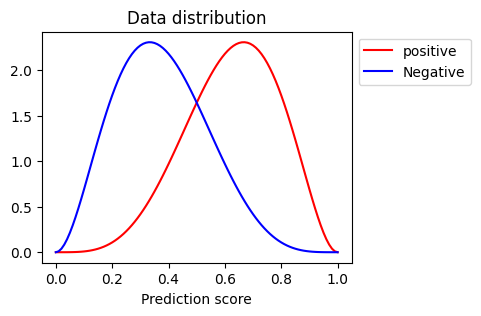

In [3]:
#| label: fig-data-distribution
#| fig-cap: "仮想データの母集団分布"

x = np.linspace(0, 1, 101)
y_p = stats.beta.pdf(x, 5, 3) # <1>
y_n = stats.beta.pdf(x, 3, 5) # <2>

plt.figure(figsize=(4, 3))
plt.plot(x, y_p, color="red", label="positive")
plt.plot(x, y_n, color="blue", label="Negative")
plt.title("Data distribution")
plt.xlabel("Prediction score")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
plt.close()

# ROC-AUC曲線及びPR-AUC曲線の確認

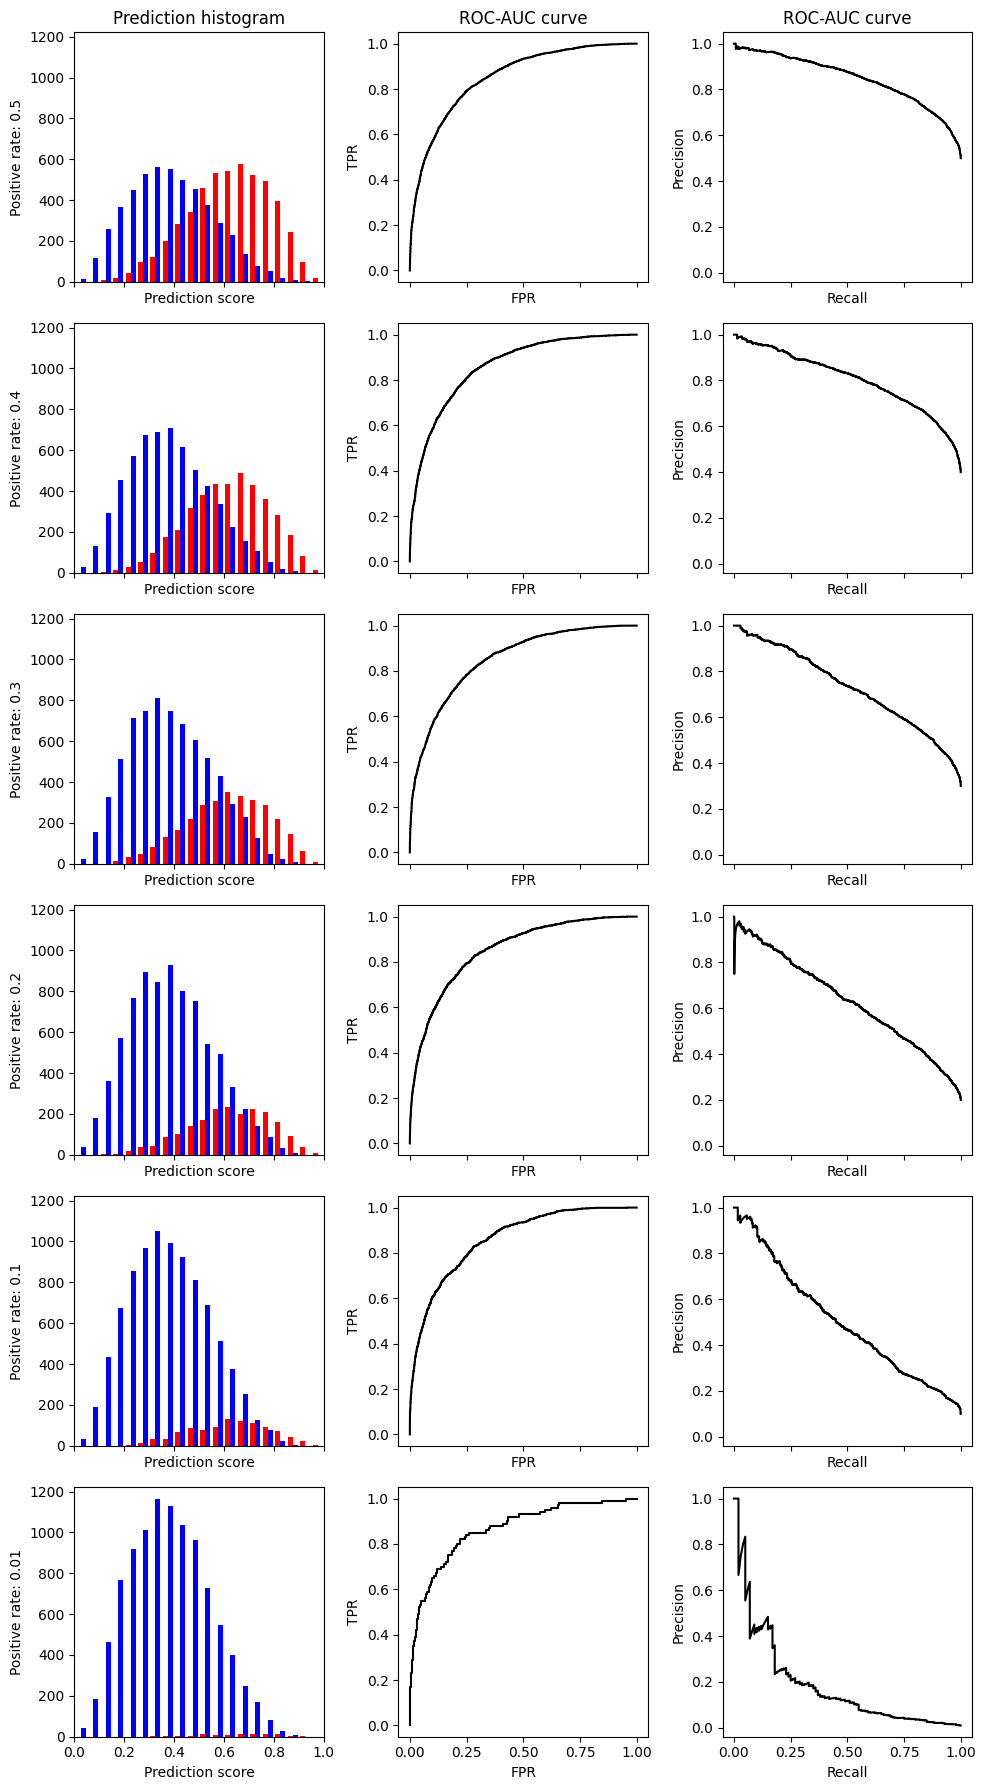

In [4]:
#| label: fig-auc-curve
#| fig-cap: "仮想データによる分布、ROC-AUC曲線、PR-AUC曲線"
#| fig-subcap: "左から予測値の分布、ROC-AUC曲線、PR-AUC曲線と並べている。真に陽性群の割合は縦で変えており、上から[0.5, 0.4, 0.3, 0.2, 0.1, 0.01]である。分布の赤は真に陽性群、青は真に陰性群を表している。"

def plot_pred(ax: plt.Axes, idx: int, y_true: np.ndarray, y_pred: np.ndarray):
    ax.set_box_aspect(1)
    ax.hist(
        [
            y_pred[y_true == 1],
            y_pred[y_true == 0],
        ],
        color=["red", "blue"],
        bins=np.linspace(0, 1, 21)
    )
    ax.set_xlim([0, 1])
    ax.set_ylabel(f"Positive rate: {posi_rate}")
    ax.set_xlabel("Prediction score")
    if idx == 0:
        ax.set_title("Prediction histogram")

def plot_roc_auc(ax: plt.Axes, idx: int, y_true: np.ndarray, y_pred: np.ndarray):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)

    ax.set_box_aspect(1)
    ax.plot(
        fpr,
        tpr,
        color="black",
    )
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    if idx == 0:
        ax.set_title("ROC-AUC curve")

def plot_pr_auc(ax: plt.Axes, idx: int, y_true: np.ndarray, y_pred: np.ndarray):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)

    ax.set_box_aspect(1)
    ax.plot(
        recall,
        precision,
        color="black",
    )
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    if idx == 0:
        ax.set_title("ROC-AUC curve")

fig, axes = plt.subplots(
    6, 3, figsize=(10, 18), sharex="col", sharey="col", tight_layout=True
)
for idx, posi_rate in enumerate(posi_rates):
    y_true, y_pred = eval_simulator.make_sample(posi_rate)
    plot_pred(axes[idx][0], idx, y_true, y_pred)
    plot_roc_auc(axes[idx][1], idx, y_true, y_pred)
    plot_pr_auc(axes[idx][2], idx, y_true, y_pred)
plt.show()
plt.close()

# 反復試行による評価指標の比較

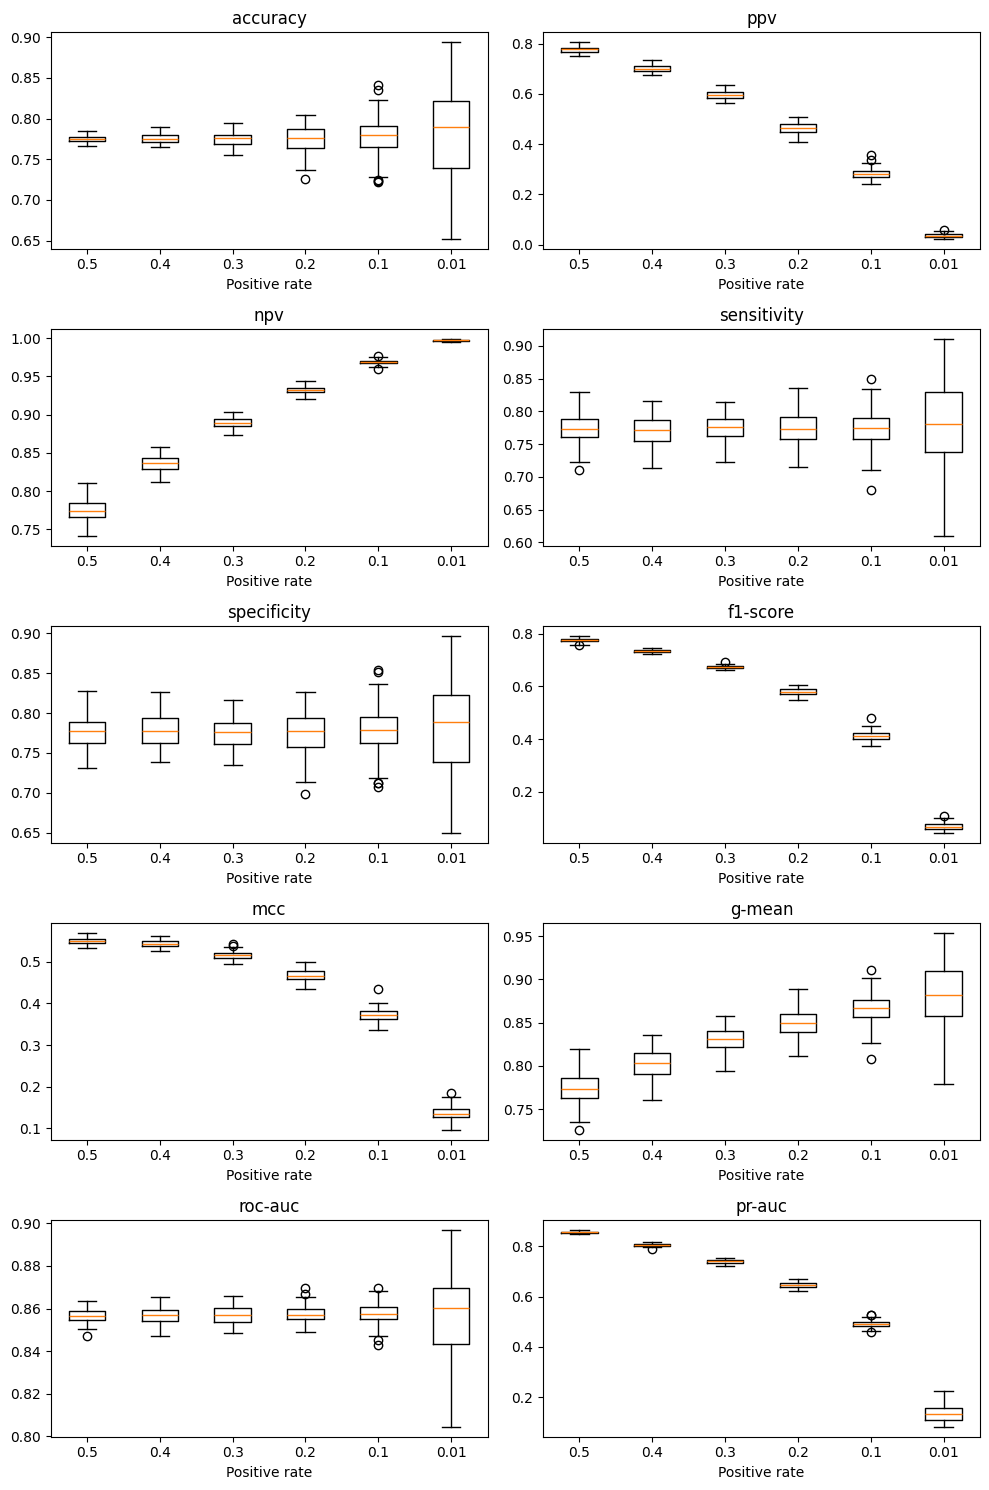

In [5]:
#| label: fig-eval-score
#| fig-cap: "仮想データによる各評価指標の分布"

eval_simulator.process(posi_rates)
fig, axes = plt.subplots(5, 2, figsize=(10, 15), tight_layout=True)

for idx, key in enumerate(eval_simulator.scores.keys()):
    axes[idx // 2][idx % 2].boxplot(
        [eval_simulator.scores[key][posi_rate] for posi_rate in posi_rates],
        tick_labels=posi_rates,
    )
    axes[idx // 2][idx % 2].set_title(key)
    axes[idx // 2][idx % 2].set_xlabel("Positive rate")

plt.show()
plt.close()